In [1]:
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.datasets.samples_generator import make_circles
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from numpy.linalg import matrix_power
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.cm as cm
from scipy import linalg
import numpy as np
import pandas as pd
import random
import math


In [2]:
var = 0.5;
n_samples = 100
mu = 1
v = 1
weight_limit = 0

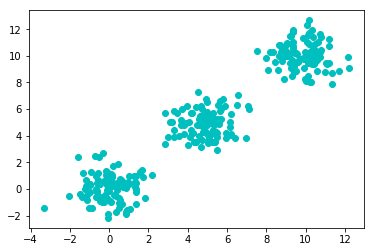

In [3]:


"""
noise = 0.1*np.random.normal(0,1,100)
X = np.ndarray(shape=(n_samples,2), dtype=float, order='F')
y = np.ndarray(shape=(n_samples), dtype=float, order='F')

x = np.arange(0,1,1/n_samples)
for t, i in zip(x, range(0,n_samples)):
    y[i] = math.sin(4*math.pi*t) + noise[i]
    X[i] = [math.cos(2*math.pi*t), math.sin(2*math.pi*t)]
"""
n_samples = 100
#beta [0 1]
x_1, y = make_blobs(n_samples=n_samples, n_features=2, centers = [[0., 0.]], cluster_std=1.0)
#beta [1 0]
x_2, y = make_blobs(n_samples=n_samples, n_features=2, centers=[[5., 5.]], cluster_std=1.0)
#beta [1 1]
x_3, y = make_blobs(n_samples=n_samples, n_features=2, centers=[[10., 10.]], cluster_std=1.0)
#X, y = make_circles(n_samples=15, shuffle=True, noise=None, random_state=None, factor=0.8)
X = np.block([[x_1], [x_2], [x_3]])

y_1 = np.zeros(n_samples)
y_2 = np.zeros(n_samples)
y_3 = np.zeros(n_samples)

X = np.array(X)
p = len(X[0,:])
n = len(X[:,0])

for i in range(0,n_samples): 
    y_1[i] = 1 + 0 * x_1[i,0]+ x_1[i,1]
    y_2[i] = 1 + 1* x_2[i,0]+0*x_2[i,1]
    y_3[i] = 1 + x_3[i,0]+ x_3[i,1]

y= np.concatenate((y_1, y_2, y_3))
#y = np.block([[y_1], [y_2], [y_3]])

fig = plt.figure()
#ax = plt.axes(projection='3d')
    
#plt.plot(X[:, 0], X[:, 1], y,'co')
plt.plot(X[:, 0], X[:, 1], 'co')
plt.show()
y_matrix = np.matrix(y)
#ax = plt.axes(projection='3d')



In [4]:
g, y_g = make_blobs(n_samples=n_samples, n_features=2, centers = [[0., 0.]], cluster_std=1.0)
var_g = 1

In [5]:
#LLR
class LLR():
    
    def __init__(self):
        self.mode = ''

     
    def fit(self, X, y_matrix, mu, v, mode='compress', perm_size = 50):
        p = len(X[0,:])
        n = len(X[:,0])
        self.perm_size = perm_size
        self.Y = np.zeros(n)
        self.W = np.zeros((len(X[:, 0]), len(X[:, 0])))
        self.X = X
        self.y = y_matrix
        
        I = np.identity(len(X[:, 0]))
        A = np.zeros((len(X[:, 0]), len(X[:, 0])))
        D = np.zeros((len(X[:, 0]), len(X[:, 0])))
        D_inv = np.zeros((len(X[:, 0]), len(X[:, 0])))
        
        # Constructing X_block matrix
        self.X_block = np.identity(len(X[:, 0]))
        for i in range(0, len(X[0,:])):
            self.X_block = np.block([self.X_block, np.diag(X[:,i])]);

        # Compute the weight matrix of X
        for i in range(0, len(X[:, 0])):
            for j in range(0, len(X[:, 0])):
                if i != j:
                    self.W[i,j] = math.exp((-1)*np.linalg.norm(X[i]-X[j])**2/var**2);    
        # Constructing D 
        for i in range(0, len(X[:, 0])):
            D[i,i] = np.sum(self.W[i,:]);
            if D[i,i] == 0:
                raise ValueError("Some vertices in the graph are not connected.")
            D_inv[i,i] = 1/D[i,i];


        L = np.subtract(I,np.matmul(D_inv, self.W))
        
        # Constructing M block matrix
        M_alpha = np.block([mu*L, np.zeros((n, n*p))]);
        M_beta = np.block([np.zeros((n,n)), (v/p)*L, np.zeros((n, n*p-n))]);

        for i in range(1, p):

            M_temp = np.block([np.zeros((n,(i+1)*n)), (v/p)*L, np.zeros((n, n*p+n-(i+2)*n))]);    
            M_beta = np.block([[M_beta], [M_temp]])

        M = np.block([[M_alpha], [M_beta]])
        M = np.mat(M);

        self.X_block = np.mat(self.X_block);
        #self.weight = self.W   
        
        if(mode == 'compress'):
            self.mode = 'compress'
            D_compress = np.zeros((len(X[:, 0]), len(X[:, 0])))
            D_inv_compress = np.zeros((len(X[:, 0]), len(X[:, 0])))
            G = np.random.normal(0, 1, (perm_size, len(X[:, 0])))
            E = np.zeros((len(X[:, 0]), perm_size))

            self.perm = random.sample(range(0, len(X[:, 0])), perm_size)
            q, r, self.perm = linalg.qr(np.matmul(G,self.W), pivoting=True)

            for i in range(0, perm_size): 
                E[:,i] = self.W[:, (self.perm[i])];
            E = np.mat(E)

            # Compute the degree matrix of the choosen columns  
            for i in range(0, len(X[:, 0])):
                D_compress[i,i] = np.sum(E[i,:]);
                if D_compress[i,i] == 0:
                    raise ValueError("Some vertices in the graph are not connected.")
                D_inv_compress[i,i] = 1/D_compress[i,i];
            
            # Compute the normalized weight matrix with the choosen columns
            self.W_asym = np.matmul(D_inv_compress, E)
            self.W_asym = np.mat(self.W_asym)

            W_A = np.block([self.W_asym, np.zeros((n, perm_size*p))]);
            for i in range(1, p+1):
                W_A_temp = np.block([np.zeros((n,i*perm_size)), self.W_asym, np.zeros((n, p*perm_size-i*perm_size))]);    
                W_A = np.block([[W_A], [W_A_temp]])
                
            '''    
            fig = plt.figure()
            plt.spy(W_A)
            plt.show()
            '''
            
            # Compute theta
            add_1 = np.matmul(W_A.transpose(), self.X_block.transpose())
            add_2 = np.matmul(self.X_block, W_A)
            sum_1 = np.matmul(add_1, add_2)

            sum_2 = np.matmul(W_A.transpose(), np.matmul(M, W_A))

            to_invert = sum_1+sum_2
            u, s, vh = np.linalg.svd((to_invert), full_matrices=True)

            for i in range(0, len(s)):
                s[i] = 1/s[i]

            inverse = np.matmul(np.matmul(vh.transpose(),np.diag(s)),u.transpose())

            self.Theta = np.matmul(W_A, np.matmul(inverse, np.matmul(W_A.transpose(), np.matmul(self.X_block.transpose(), y_matrix.transpose()))))
            
            self.weight = self.W_asym
            
            n = len(X[:,:])
            for i in range(0, len(X[:,:])):
                #Y[i] = Theta[i,0] + Theta[i+n, 0] * X[i,0]+Theta[i+n+1,0] * X[i,1]
                self.Y[i] = self.Theta[i,0] + self.Theta[i+n, 0]*X[i,0]+self.Theta[i+2*n,0]*X[i,1]
            
           
        if(mode == 'test'):  
            self.mode = 'test'
            D_compress = np.zeros((len(X[:, 0]), len(X[:, 0])))
            D_inv_compress = np.zeros((len(X[:, 0]), len(X[:, 0])))
            G = np.random.normal(0, 1, (perm_size, len(X[:, 0])))
            E = np.zeros((len(X[:, 0]), perm_size))
            
            # to store data of the reduced X
            W_small = np.zeros((perm_size, perm_size))
            A = np.zeros((perm_size, perm_size))
            D = np.zeros((perm_size, perm_size))
            D_inv = np.zeros((perm_size, perm_size))

            self.perm = random.sample(range(0, len(X[:, 0])), perm_size)
            #q, r, self.perm = linalg.qr(np.matmul(G,self.W), pivoting=True)
            
            # pick the columns of W with biggest eigenvalues
            for i in range(0, perm_size): 
                E[:,i] = self.W[:, (self.perm[i])];
            E = np.mat(E)

            # Compute the degrees of the choosen columns 
            for i in range(0, len(X[:, 0])):
                D_compress[i,i] = np.sum(E[i,:]);
                if D_compress[i,i] == 0:
                    raise ValueError("Some vertices in the graph are not connected.")
                D_inv_compress[i,i] = 1/D_compress[i,i];

            # Compute the normalized wieght matrix of the choosen columns
            self.W_asym = np.matmul(D_inv_compress, E)
            self.W_asym = np.mat(self.W_asym)

            W_A = np.block([self.W_asym, np.zeros((n, perm_size*p))]);
            for i in range(1, p+1):
                W_A_temp = np.block([np.zeros((n,i*perm_size)), self.W_asym, np.zeros((n, p*perm_size-i*perm_size))]);    
                W_A = np.block([[W_A], [W_A_temp]])
                
            # Compute the square weight matrix with only the choosen columns of X
            n = perm_size
            for i in range(0, perm_size):
                for j in range(0, perm_size):
                    if i != j:
                        W_small[i,j] = math.exp((-1)*np.linalg.norm(X[self.perm[i]]-self.X[self.perm[j]])**2/var**2);  

            # Find the degree of the columns of the reduced X matrix  
            for i in range(0, perm_size):
                D[i,i] = np.sum(W_small[i,:]);
                if D[i,i] == 0:
                    raise ValueError("Some vertices in the graph are not connected.")
                D_inv[i,i] = 1/D[i,i];

            #W_A = np.matmul(D_inv, W_small)
            # Compute the Laplacian matrix of reduced X matrix
            L = np.subtract(np.identity(perm_size), np.matmul(D_inv, W_small))
            
            # Keep only the choosed columns of X and their y values
            X_new = self.X[self.perm[0], :]
            y_new = y[self.perm[0]]
            
            for i in range(1, perm_size):
                X_new = np.block([[X_new], [self.X[self.perm[i], :]]])
                y_new = np.block([[y_new],[y[self.perm[i]]]])   
                
            # Constructing X_block matrix of smaller X
            self.X_block = np.identity(perm_size)
            for i in range(0, 2):
                self.X_block = np.block([self.X_block, np.diag(X_new[:,i])]);
            
            # Constructing M block matrix of smaller X
            M_alpha = np.block([mu*L, np.zeros((perm_size, perm_size*p))]);
            M_beta = np.block([np.zeros((perm_size,perm_size)), (v/p)*L, np.zeros((perm_size, perm_size*p-perm_size))]);

            for i in range(1, p):

                M_temp = np.block([np.zeros((perm_size,(i+1)*perm_size)), (v/p)*L, np.zeros((perm_size, perm_size*p+perm_size-(i+2)*perm_size))]);    
                M_beta = np.block([[M_beta], [M_temp]])

            M = np.block([[M_alpha], [M_beta]])
            M = np.mat(M);
            '''
            fig = plt.figure()
            plt.imshow(M)
            plt.show()
            '''
            #Compute the theta of smaller X 
            self.X_block = np.mat(self.X_block);
            to_invert = np.matmul(self.X_block.transpose(),self.X_block) + M
            u, s, vh = np.linalg.svd((to_invert), full_matrices=True)

            for i in range(0, len(s)):
                s[i] = 1/s[i]

            inverse = np.matmul(np.matmul(vh.transpose(),np.diag(s)),u.transpose())
            self.Theta = np.matmul(np.matmul(inverse,self.X_block.transpose()),y_new)
            
            #extrapolate theta to the whole dataset
            Theta = np.matmul(W_A, self.Theta); 
            self.weight = W_A
            
            # Compute the predicted y values
            n = len(X[:,:])
            for i in range(0, len(X[:,:])):
                #Y[i] = Theta[i,0] + Theta[i+n, 0] * X[i,0]+Theta[i+n+1,0] * X[i,1]
                self.Y[i] = Theta[i,0] + Theta[i+n, 0]*X[i,0]+Theta[i+2*n,0]*X[i,1]
            
        else:
            
            '''
            fig = plt.figure()
            plt.imshow(M)
            plt.show()
            '''
            
            # Compute theta on the whole dataset 
            to_invert = np.matmul(self.X_block.transpose(),self.X_block) + M
            u, s, vh = np.linalg.svd((to_invert), full_matrices=True)

            for i in range(0, len(s)):
                s[i] = 1/s[i]

            inverse = np.matmul(np.matmul(vh.transpose(),np.diag(s)),u.transpose())
            self.Theta = np.matmul(np.matmul(inverse,self.X_block.transpose()),y_matrix.transpose())
            
            # Compute the predicted y values
            n = len(X[:,:])
            for i in range(0, len(X[:,:])):
                #Y[i] = Theta[i,0] + Theta[i+n, 0] * X[i,0]+Theta[i+n+1,0] * X[i,1]
                self.Y[i] = self.Theta[i,0] + self.Theta[i+n, 0]*X[i,0]+self.Theta[i+2*n,0]*X[i,1]

        return self
    
    def predict_test(self, X_new):
        if self.mode is not 'test':
            return
        print("predict test mode")
        
        # Prediction vector
        Y = np.zeros(len(X_new[:,0]))
        
        # Asymmetric weight vector 
        W_new = np.zeros((len(X_new[:,0]), self.perm_size))
        
        # Find the distance between the new X values and X values in the model 
        for i in range(0, len(X_new[:,0])):
            for j in range(0, self.perm_size):
                W_new[i,j] = math.exp((-1)*np.linalg.norm(X_new[i]-self.X[self.perm[j]])**2/var**2); 
        
        # Add the new rows of prediction to the wieght matrix of the model
        W_predict = W_new
        
        ''' # Constructing X_block matrix
        self.X_block = np.identity(len(X[:, 0])+len(X_new[:, 0]))
        
        for i in range(0, len(X[0,:])):
            self.X_block = np.block([self.X_block, np.diag(X[:,i])]);'''
              
        # Normalize the weight matrix
        for i in range(0, len(W_predict[:, 0])):
            d = np.sum(W_predict[i,:]);
            if d == 0:
                raise ValueError("Some vertices in the graph are not connected.")
            W_predict[i,:] = W_predict[i,:]/d;
            
        size = self.perm_size
        
        # Construct a block diagonal weight matrix with the new assymentric weight matrix
        W_A = np.block([W_predict, np.zeros((len(W_predict[:,0]), size*p))]);
        for i in range(1, p+1):
            W_A_temp = np.block([np.zeros((len(W_predict[:,0]),i*size)), W_predict, np.zeros((len(W_predict[:,0]), p*size-i*size))]);    
            W_A = np.block([[W_A], [W_A_temp]])
        
        # Extrapolate the previously computed theta to the new dataset
        Theta = np.matmul(W_A, self.Theta)
        
        # Compute the prediction 
        for i in range(0, len(X_new[:,0])):
            #Y[i] = Theta[i,0] + Theta[i+n, 0] * X[i,0]+Theta[i+n+1,0] * X[i,1]
            
            Y[i] = Theta[i,0] + Theta[i+len(X_new[:,0]), 0]*X_new[i,0]+Theta[i+2*len(X_new[:,0]),0]*X_new[i,1]
            
        return Y   
    
    def predict_compress(self, X_new, y_new):
        if self.mode is not 'compress':
            return
        print("predict compress mode")
            
        # Prediction vector
        Y = np.zeros(len(X_new[:,0]))
        
        # Compute the weights of the new dataset against the old one
        W_new = np.zeros((len(X_new[:,0]), self.perm_size))
        for i in range(0, len(X_new[:,0])):
            for j in range(0, self.perm_size):
                W_new[i,j] = math.exp((-1)*np.linalg.norm(X_new[i]-self.X[self.perm[j]])**2/var**2); 
          
        # Add the weights as new rows to the weight matrix of the model
        W_predict = np.block([[self.W_asym], [W_new]])
        
        # Add the new data to the dataset of the model
        X = np.block([[self.X], [X_new]])
        y_matrix = np.block([self.y, y_new])
        
        W = np.zeros((len(X[:,0]),len(X[:,0])))
        n = len(X[:,0])
        
        # Constructing X_block matrix
        self.X_block = np.identity(len(X[:, 0]))
        for i in range(0, len(X[0,:])):
            self.X_block = np.block([self.X_block, np.diag(X[:,i])]);
        
       # Compute the weight matrix
        for i in range(0, len(X[:, 0])):
            for j in range(0, len(X[:, 0])):
                if i != j:
                    W[i,j] = math.exp((-1)*np.linalg.norm(X[i]-X[j])**2/var**2);    
        
        # Compute the degree matrix
        for i in range(0, len(X[:, 0])):
            d = np.sum(W[i,:]);
            if d == 0:
                raise ValueError("Some vertices in the graph are not connected.")
            W[i,j] = W[i,j]/d;
            
        # Constructing D 
        for i in range(0, len(W_predict[:, 0])):
            d = np.sum(W_predict[i,:]);
            if d == 0:
                raise ValueError("Some vertices in the graph are not connected.")
            W_predict[i,:] = W_predict[i,:]/d;
            
        size = self.perm_size
        
        L = np.subtract(np.identity(len(X[:,0])),W)
        # Constructing M block matrix
        M_alpha = np.block([mu*L, np.zeros((n, n*p))]);
        M_beta = np.block([np.zeros((n,n)), (v/p)*L, np.zeros((n, n*p-n))]);

        for i in range(1, p):

            M_temp = np.block([np.zeros((n,(i+1)*n)), (v/p)*L, np.zeros((n, n*p+n-(i+2)*n))]);    
            M_beta = np.block([[M_beta], [M_temp]])

        M = np.block([[M_alpha], [M_beta]])
        M = np.mat(M);
        
        
        W_A = np.block([W_predict, np.zeros((len(W_predict[:,0]), size*p))]);
        for i in range(1, p+1):
            W_A_temp = np.block([np.zeros((len(W_predict[:,0]),i*size)), W_predict, np.zeros((len(W_predict[:,0]), p*size-i*size))]);    
            W_A = np.block([[W_A], [W_A_temp]])
        
        # Compute theta
        add_1 = np.matmul(W_A.transpose(), self.X_block.transpose())
        add_2 = np.matmul(self.X_block, W_A)
        sum_1 = np.matmul(add_1, add_2)

        sum_2 = np.matmul(W_A.transpose(), np.matmul(M, W_A))

        to_invert = sum_1+sum_2
        u, s, vh = np.linalg.svd((to_invert), full_matrices=True)

        for i in range(0, len(s)):
            s[i] = 1/s[i]

        inverse = np.matmul(np.matmul(vh.transpose(),np.diag(s)),u.transpose())

        self.Theta = np.matmul(W_A, np.matmul(inverse, np.matmul(W_A.transpose(), np.matmul(self.X_block.transpose(), y_matrix.transpose()))))
            
        self.weight = self.W_asym
            
        n = len(X[:,:])
        for i in range(0, len(X_new[:,:])):
            #Y[i] = Theta[i,0] + Theta[i+n, 0] * X[i,0]+Theta[i+n+1,0] * X[i,1]
            self.Y[i] = self.Theta[i,0] + self.Theta[i+n, 0]*X[i,0]+self.Theta[i+2*n,0]*X[i,1]
            
        '''      
        Theta = np.matmul(W_A, self.Theta)
        for i in range(0, len(X_new[:,0])):
            #Y[i] = Theta[i,0] + Theta[i+n, 0] * X[i,0]+Theta[i+n+1,0] * X[i,1]
            
            Y[i] = Theta[i,0] + Theta[i+n, 0]*X_new[i,0]+Theta[i+2*n,0]*X_new[i,1]
            '''
        return Y 
    

0
mu= 2
v= 0.5
predict test mode
predict test mode
predict test mode
predict test mode
predict test mode
[24.300238  0.        0.        0.        0.        0.        0.
  0.        0.        0.      ]
[25.62099817  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


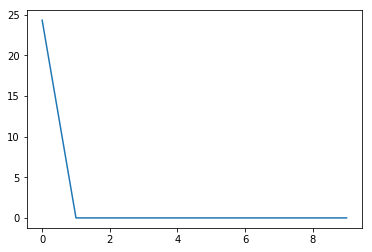

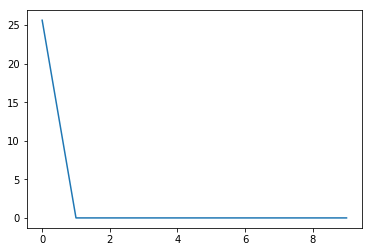

In [6]:
kf = KFold(n_splits=5, shuffle=True)
count = 0 
n_range = 100
step = 5
MSE_test = np.zeros(5)
MSE_train = np.zeros(5)
MSE_avg_test = np.zeros(10)
MSE_avg_train = np.zeros(10)


while (count < 1):
    rand_mu = random.randint(1, 2)
    rand_v = random.randint(1, 2)
    print(count)
    print("mu=", rand_mu)
    print("v=", rand_v/p)
    index=0
    
    for train_index, test_index in kf.split(X):
        
        #print("TRAIN:", train_index, "\nTEST:", test_index)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_matrix = np.matrix(y_train)
        p = len(X_train[0,:])
        n = len(X_train[:,0])
        perm_size = int(len(X_train[:,0])/2)
        llr = LLR()
        #regression = llr.fit(X_train, y_matrix, rand_mu, rand_v/p, mode='test', perm_size=200)
        regression = llr.fit(X_train, y_matrix, 1, 1, mode='test', perm_size=200)
        #Theta = regression.Theta
        #(Theta_train, perm_test) = LLR(X_train, y_matrix, n, p, rand_mu, rand_v/p, compression=True,  perm_size = perm_size)
        '''
        print(Theta_train.shape)
        W_test = np.zeros(perm_size);
                          
        for i in range(0, len(X_test[:, 0])):
            for j in range( 0, len(perm_test)):
                W_test[i,j] = math.exp((-1)*np.linalg.norm(i-X_train[j])**2/var**2);
        '''
        Y_train = regression.Y
        
        Y_test = regression.predict_test(X_test)
        #Y_test = regression.predict_compress(X_test, y_test)
        '''for i in range(0, len(y_train)):
            Y_train[i] = Theta_train[i,0] + Theta_train[i+n, 0] * X_train[i,0]+Theta_train[i+2*n,0] * X_train[i,1]
        
        for i in range(0, len(y_test)):
            for j in range( 0, int(len(X_test[:,0])/2)):
                W_test[j] = math.exp((-1)*np.linalg.norm(X_test[i]-X_train[perm_test[j]])**2/var**2);
            Y_test[i] =  Theta_train[i,0] + Theta_train[i+n, 0] * X_test[i,0]+Theta_train[i+2*n,0] * X_test[i,1]
        Y_test = W_test*Y_test'''
        
        
        MSE_test[index] = mean_squared_error(y_test, Y_test);
        MSE_train[index] = mean_squared_error(y_train, Y_train);
        index+=1

 
    MSE_avg_test[count] = np.average(MSE_test)
    MSE_avg_train[count] = np.average(MSE_train)
    count+=1  

    #fig = plt.figure()
    #plt.plot(range(0, 5),MSE)
    #plt.show()
            
            
print(MSE_avg_test)
print(MSE_avg_train)

fig = plt.figure()
plt.plot(range(0, 10),MSE_avg_test)
plt.show()

plt.plot(range(0, 10),MSE_avg_train)
plt.show()
    

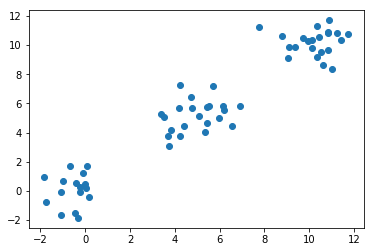

In [34]:
plt.scatter(X_test[:,0],X_test[:,1])

predict test mode
1.3774802134977082
MSE =  3.380538225920555


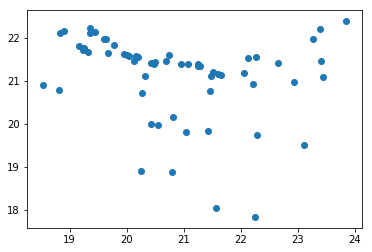

In [10]:
p = len(X[0,:])
n = len(X[:,0])
x = np.arange(0,240,1)
y_matrix = np.matrix(y[1:240])
#x = np.linspace(0,100,1)
Theta = np.zeros(3*n)
llr = LLR()
regression = llr.fit(X[1:240], y_matrix, mu, v, mode='test', perm_size=150)
Theta = regression.Theta
Y = regression.Y
#Y_test = regression.predict_compress(X[240:300,:], np.matrix(y[240:300]))
Y_test = regression.predict_test(X[240:300])
Theta_real = np.zeros(3*n)
for i in range(0, n):
    Theta_real[i] = 1
    
for i in range(n, int(n/3)):
    Theta_real[i] = 0
for i in range(int(n+n/3), int(2*n)):
    Theta_real[i] = 1

for i in range(2*n, int(2*n+n/3)):
    Theta_real[i] = 1
for i in range(int(2*n+n/3), int(2*n+2*n/3)):
    Theta_real[i] = 0
for i in range(int(2*n+2*n/3), 3*n):
    Theta_real[i] = 1

'''for i in range(0, n):
    #Y[i] = Theta[i,0] + Theta[i+n, 0] * X[i,0]+Theta[i+n+1,0] * X[i,1]
    Y[i] = Theta[i,0] + Theta[i+n, 0]*X[i,0]+Theta[i+2*n,0]*X[i,1]
'''
#plt.plot(x, Theta[n:2*n, 0], 'c', label = "Beta 1")
#plt.plot(x, Theta[2*n:3*n, 0], 'k', label = "Beta 2")
#plt.plot(x, Theta[0:n, 0], 'r', label = "Alpha")

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.show() 


'''plt.plot(x, y, 'k', label = "Real y")
plt.plot(x, Y, 'r', label = "Estimate of y")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show() '''


#plt.plot(Theta, range(0, 3*n), label = "Estimate of Theta")
#plt.plot(Theta_real, range(0, 3*n), label = "Real Theta")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.show()  
MSE = mean_squared_error(y[1:240], Y);
MSE_test = mean_squared_error(y[240:300], Y_test);
print(MSE)
print("MSE = ", MSE_test)
plt.figure()
plt.scatter(y[240:300], Y_test)
#plt.plot(Theta_real, range(0, 3*n), label = "Real Theta")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show() 
#print(Theta)


In [18]:
#RNC  
W = np.zeros((len(X[:, 0]), len(X[:, 0])))
A = np.zeros((len(X[:, 0]), len(X[:, 0])))
D = np.zeros((len(X[:, 0]), len(X[:, 0])))
D_1_2_inv = np.zeros((len(X[:, 0]), len(X[:, 0])))
I = np.identity(len(X[:, 0]))

for i in range(0, len(X[:, 0])):
    for j in range(0, len(X[:, 0])):
        W[i][j] = math.exp((-1)*np.linalg.norm(X[i]-X[j])**2/var**2);    

# Constructing A based on weights 
for i in range(0, n):
    for j in range(0, n):
        if W[i][j] > weight_limit and i != j:
            A[i][j] = 1;


# Constructing D 
for i in range(0, len(X[:, 0])):
    D[i][i] = np.sum(A[i]);
    if D[i][i] == 0:
        raise ValueError("Some vertices in the graph are not connected.")
    D_1_2_inv[i][i] = 1/math.sqrt(D[i][i]);

L = np.subtract(D,W)
#L = np.matmul(np.matmul(D_1_2_inv, L), D_1_2_inv)
    
M_rnc_1 = np.block([0.5*L, np.zeros((n,p))]);
M_rnc_2 = np.block([np.zeros((p, n)), np.zeros((p,p))]);
M_rnc = np.block([[M_rnc_1], [M_rnc_2]])
X_rnc = np.block([np.identity(n),X])
X_rnc = np.mat(X_rnc);
M_rnc = np.mat(M_rnc);

to_invert_rnc = np.matmul((X_rnc.T),X_rnc)+M_rnc; 
Theta_rnc = np.matmul(np.matmul((to_invert_rnc).I,X_rnc.T),y_matrix.T)
Y = np.zeros(n)


for i in range(0, n-1):
        #Y[i] = Theta[i,0] + Theta[i+n, 0] * X[i,0]+Theta[i+n+1,0] * X[i,1]
    Y[i] = Theta_rnc[i,0] + Theta_rnc[n, 0] * X[i,0]+Theta_rnc[n+1,0] * X[i,1]
    
x = np.arange(0,n,1)
plt.plot(x, Theta_rnc[0:n, 0], 'r', label = "Alpha")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show() 


plt.plot(x, y, 'k', label = "Real y")
plt.plot(x, Y, 'r', label = "Estimate of y")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show() 

MSE = mean_squared_error(y, Y);
print("MSE = ", MSE)


ValueError: shapes (302,300) and (240,1) not aligned: 300 (dim 1) != 240 (dim 0)